# Shuffle and learn

Train encoder to predict if 3 frames are in correct temporal order or not.  
Paper: https://arxiv.org/abs/1603.08561

In [1]:
import cv2

import sys

sys.path.append('/scratch/mz2476/DL/project/')

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
from ssl_project.data_loaders import plot_utils

import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ssl_project.data_loaders.data_helper import UnlabeledDataset, LabeledDataset
from ssl_project.data_loaders.helper import collate_fn, draw_box
from ssl_project import constants

from ssl_project.preprocessing import top_down_segmentation


from ssl_project.utils import to_np

In [15]:
from ssl_project.constants import *
from ssl_project.paths import *

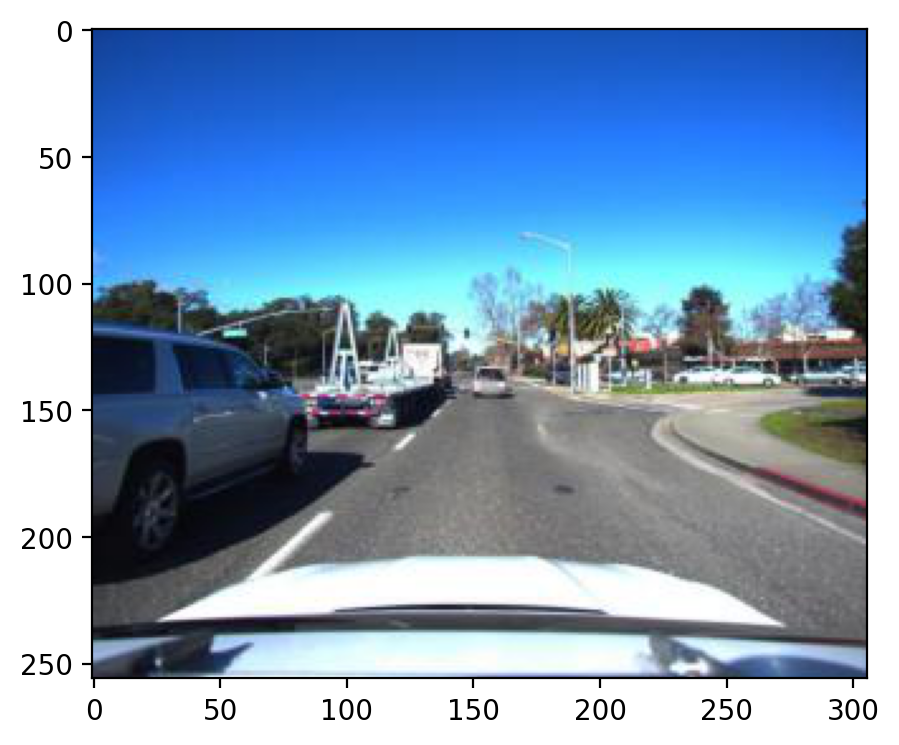

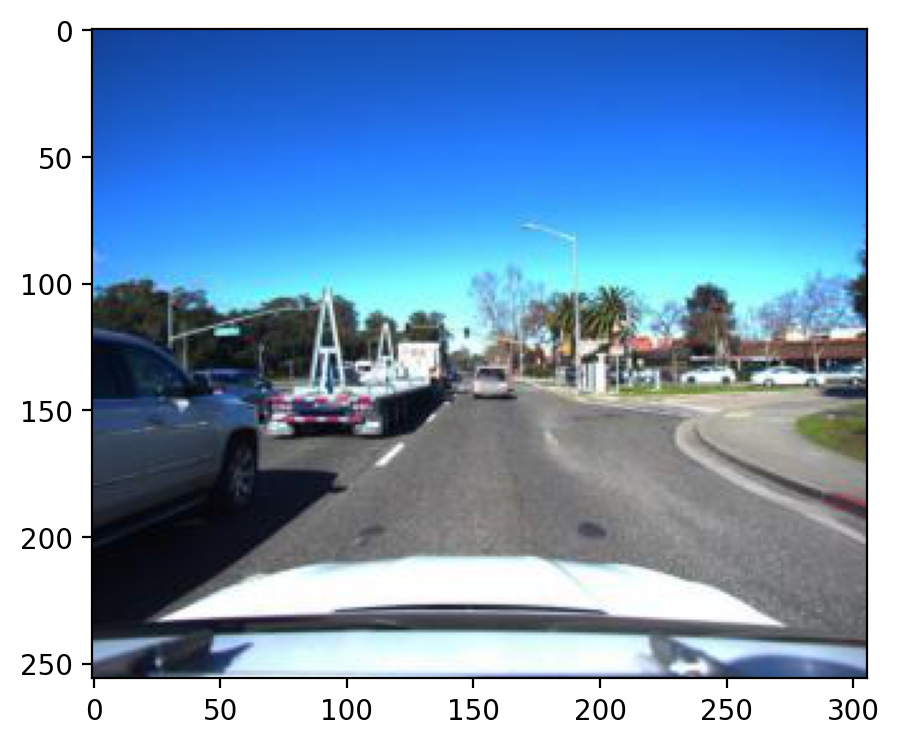

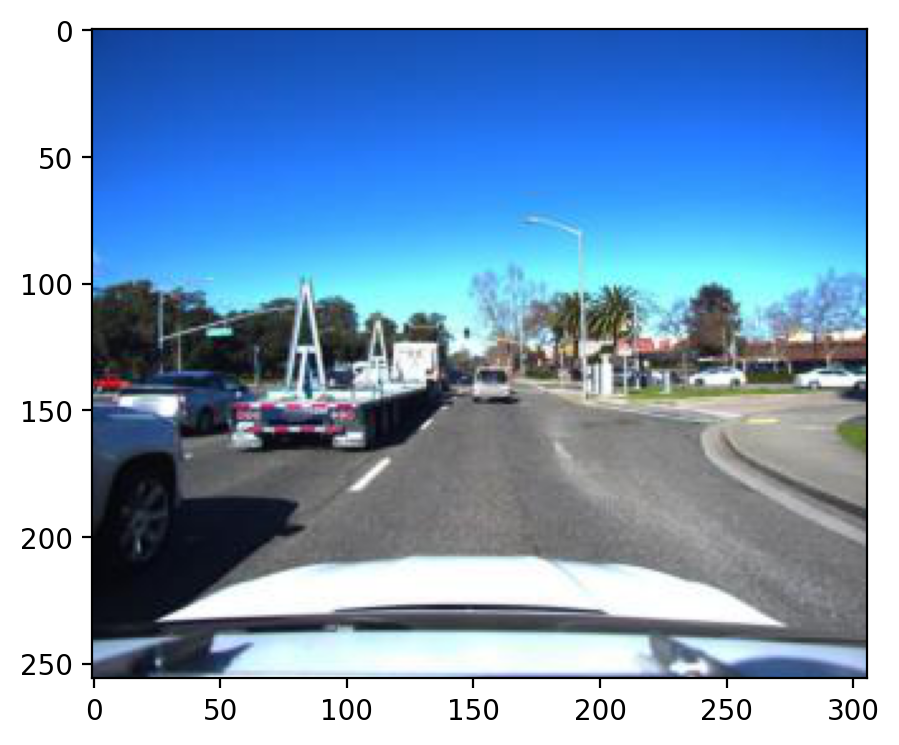

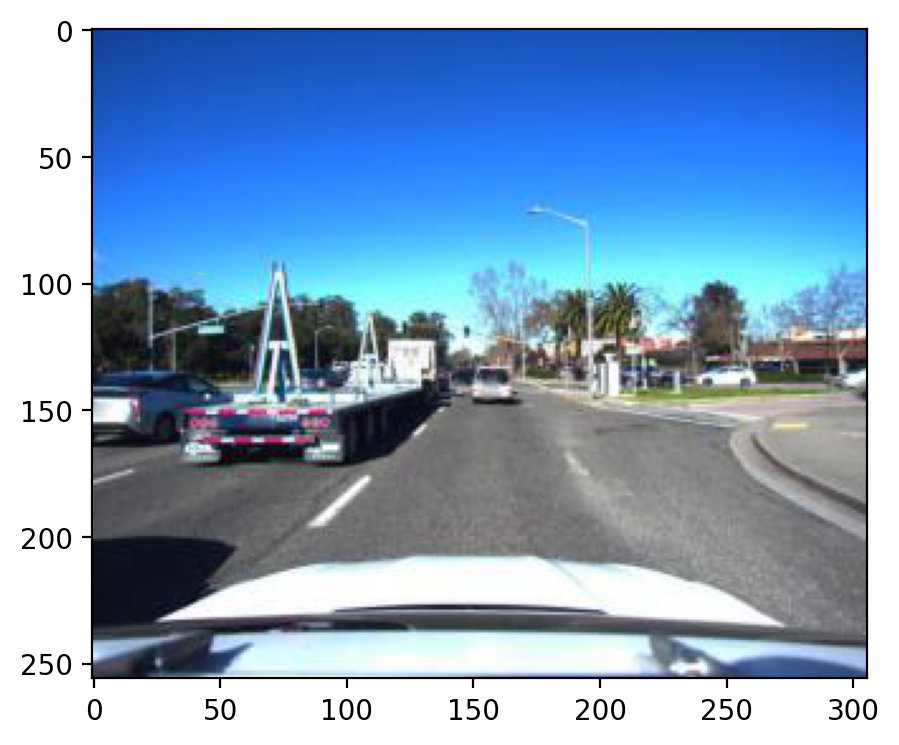

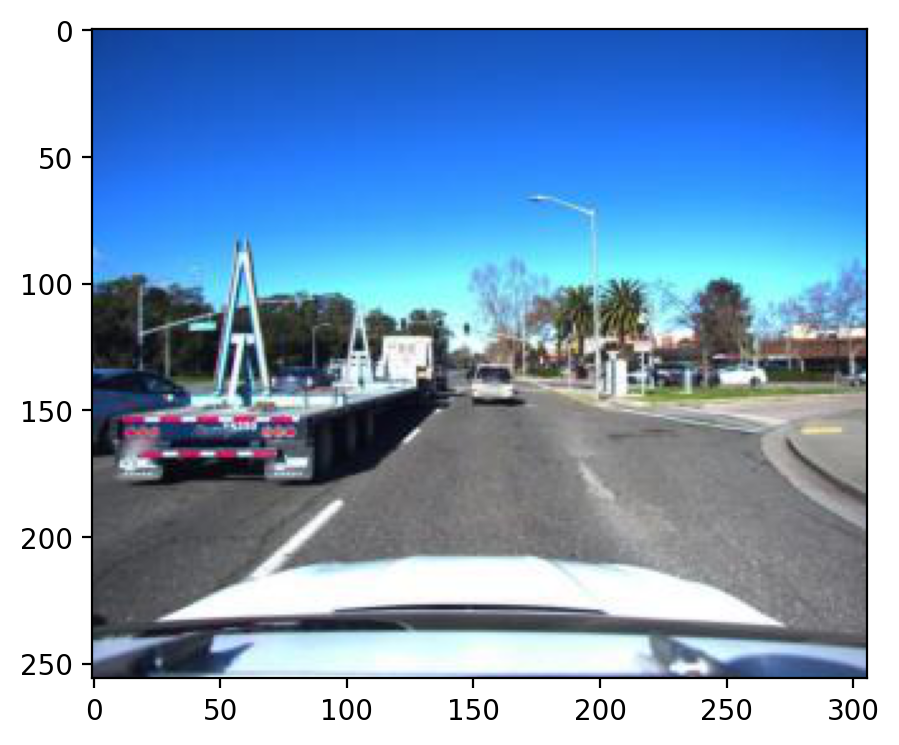

In [26]:
for idx in range(5):
    img = imageio.imread(f"../data/scene_30/sample_{idx}/CAM_FRONT.jpeg")
    plt.imshow(img)
    plt.show()

In [28]:
NUM_SAMPLE_PER_SCENE

126

In [49]:
def load_image(scene_id, cam_name, sample_id, transform=TRANSFORM):
    path = os.path.join(PATH_TO_DATA, f'scene_{scene_id}', f'sample_{sample_id}',  f"{cam_name}.jpeg") 
    image = Image.open(path)
    return transform(image)


def TripleDataset(cam_names=CAM_NAMES, scene_ids=None):
    """it is a function which returns an instance of TripleDataset"""
    idces_offset_with_label = [
         ([0, 1, 2], 1),    # positive_1
         ([0, 3, 2], 0),
         ([1, 0, 3], 0),
    ]

#     idces_offset_with_label = [
#          ([0, 1], 1), # forward or backward
#          ([1, 0], 0),
#     ]


    my_datasets = []
    for cam_name in cam_names: # maybe you want just one CAM_NAME
        for scene_id in scene_ids:
            for idces_offset, label in idces_offset_with_label:
                cur_dataset = _HelperForTripleDataset(cam_name, scene_id, idces_offset, label)
                my_datasets.append(cur_dataset)

    super_dataset = torch.utils.data.ConcatDataset(my_datasets)
    
    return super_dataset


class _HelperForTripleDataset:
    def __init__(self, cam_name, scene_id, idces_offset, label):
        self.cam_name = cam_name
        self.scene_id = scene_id
        self.idces_offset = idces_offset
        self.label = label
        
    def __len__(self):
        return NUM_SAMPLE_PER_SCENE - max(self.idces_offset)
    
    def __getitem__(self, idx):
        """
        return 
            images_o3hw, self.label
        """
        # where n_o = num offsets
        images_o3hw = torch.stack([
            load_image(self.scene_id, self.cam_name, idx + offset)
            for offset in self.idces_offset
        ])
        
        return images_o3hw, self.label

In [50]:
# torch.utils.data.ConcatDataset??

In [55]:
train_dataset = TripleDataset(cam_names=["CAM_FRONT"], scene_ids=[1])
len(train_dataset)

370

In [54]:
124 * 6

744

In [52]:
len(_HelperForTripleDataset("CAM_FRONT", 1, [0,1,2], 1))

124

In [53]:
NUM_SAMPLE_PER_SCENE

126

In [44]:
# train_dataset[0]

In [40]:
train_dataset.datasets

20

In [ ]:
class Net:
    
    
    def forward(self, three_images_bo3hw):
        assert three_images_bo3hw.shape[1] == 3, "we expect 3 images"
        emb_1_bK = self.encoder(three_images_bo3hw[:, 0])
        emb_2_bK = self.encoder(three_images_bo3hw[:, 1])
        emb_3_bK = self.encoder(three_images_bo3hw[:, 2])
        
        return self.classifier(emb_1_bK, emb_2_bK, emb_3_bK)

In [30]:
torch.utils.data.ConcatDataset??

In [ ]:


    return super_dataset

In [23]:
index = 5
cam_name = CAM_NAMES[index % ]


scene_id = 0
window_size = 5
for cur_sample_id in range(NUM_SAMPLE_PER_SCENE - window_size + 1):
    cam_name = "CAM_FRONT"
#     path_to_cur_sample = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}',  f"{image_name}.jpeg") 
    
    frames = {}
    for order_id in range(5):
        sample_id = cur_sample_id + order_id
        path = os.path.join(PATH_TO_DATA, f'scene_{scene_id}', f'sample_{sample_id}',  f"{cam_name}.jpeg") 
        image = Image.open(path)
        frames[order_id] = TRANSFORM(image)
    # positive example
    ((frames[1], frames[2], frames[3]), 1)
    
    # negative example
    ((frames[1], frames[4], frames[3]), 0)
    
    ((frames[1], frames[0], frames[3]), 0)
    break
#             images = []
#             for image_name in CAM_NAMES:
#                 image_path = os.path.join(sample_path, f"{image_name}.jpeg")
#                 image = Image.open(image_path)
#                 images.append(self.transform(image))
#             image_tensor = torch.stack(images)

(9, 256, 306)


In [27]:
NUM_SAMPLE_PER_SCENE

126

In [ ]:
class TripletsDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        image_folder=PATH_TO_DATA, 
        scene_index=UNLABELED_SCENE_INDEX, 
        first_dim='sample', 
        transform=TRANSFORM):
        """
        Args:
            image_folder (string): the location of the image folder
            scene_index (list): a list of scene indices for the unlabeled data 
            first_dim ({'sample', 'image'}), default: 'sample':
                'sample' will return [batch_size, NUM_IMAGE_PER_SAMPLE, 3, H, W]
                'image' will return [batch_size, 3, H, W] and the index of the camera [0 - 5]
                    CAM_FRONT_LEFT: 0
                    CAM_FRONT: 1
                    CAM_FRONT_RIGHT: 2
                    CAM_BACK_LEFT: 3
                    CAM_BACK.jpeg: 4
                    CAM_BACK_RIGHT: 5
            transform (Transform): The function to process the image
        """

        self.image_folder = image_folder
        self.scene_index = scene_index
        self.transform = transform

        assert first_dim in ['sample', 'image']
        self.first_dim = first_dim

    def __len__(self):
        if self.first_dim == 'sample':
            return self.scene_index.size * NUM_SAMPLE_PER_SCENE
        elif self.first_dim == 'image':
            return self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
    
    def __getitem__(self, index):
        if self.first_dim == 'sample':
            scene_id = self.scene_index[index // NUM_SAMPLE_PER_SCENE]
            sample_id = index % NUM_SAMPLE_PER_SCENE
            sample_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}') 

            images = []
            for image_name in CAM_NAMES:
                image_path = os.path.join(sample_path, f"{image_name}.jpeg")
                image = Image.open(image_path)
                images.append(self.transform(image))
            image_tensor = torch.stack(images)
            
            return image_tensor

        elif self.first_dim == 'image':
            scene_id = self.scene_index[index // (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
            sample_id = (index % (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
            image_name = CAM_NAMES[index % NUM_IMAGE_PER_SAMPLE] + ".jpeg"

            image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 
            
            image = Image.open(image_path)

            return self.transform(image), index % NUM_IMAGE_PER_SAMPLE

In [2]:
class encoder(nn.Module):
    def __init__(self, resnet_style='18', pretrained=False):
        super(encoder, self).__init__()
        self.resnet_style = resnet_style
        self.pretrained = pretrained
        if self.resnet_style == '18' and self.pretrained==False:
            resnet = models.resnet18(pretrained=False)
            
        elif self.resnet_style == '18' and self.pretrained==True:
            resnet = models.resnet18(pretrained=True)
            
        if self.resnet_style == '50' and self.pretrained==False:
            resnet = models.resnet50(pretrained=False)
            
        if self.resnet_style == '50' and self.pretrained==True:
            resnet = models.resnet50(pretrained=True)
            
        resnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(8, 8))
        
        if self.resnet_style == '18':
            self.resnet_encoder = nn.Sequential(*list(resnet.children())[:-1])
        elif self.resnet_style == '50':
            self.resnet_encoder = nn.Sequential(*list(resnet.children())[:-1], nn.Conv2d(2048, 512, 1))

    def forward(self, x):
        x = self.resnet_encoder(x)
        return x
    
    def summarize(self,x,offset=''):
        print(offset+'Class: {}'.format(type(self).__name__))
        print(offset+'resnet_style: {}, pretrained: {}'.format(self.resnet_style,self.pretrained))
        print(offset+'Passed Input Size:{}'.format(x.shape))
        print(offset+'Output Size:{}'.format(self.forward(x).shape))

In [4]:
net = encoder
net.summarize()

TypeError: summarize() missing 2 required positional arguments: 'self' and 'x'